## Antiguo proyecto de Redes Neuronales Recurrentes usando audios .wav, obteniendo su MFCC, aplicandolos a una RNN y validandolo con k fold cross validation

#### Recreación del modelo previo de Calliconde

#### Librerias

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
import librosa
import librosa.display
import os
import soundfile as sf
import json
import random
from sklearn import preprocessing
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

from keras import Sequential
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.layers import Embedding
from keras.layers import RepeatVector
from keras.layers import TimeDistributed

import datetime
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
random.seed(0)

#### Funciones a usar

In [2]:
#Obtiene el path con el nombre de todos los archivos de un directorio.
def get_files_from_path(directory):
    path_files = []
    dir_list = os.listdir(directory)
    for path in dir_list:
        path_files.append(directory+"\\"+path)
    return path_files


#Extrae los paths que cumplan con un codigo
def extract_paths_for_keys(codes, files_path, get_code):
    paths = []
    codes_set = set(codes)
    for code_file in files_path:
        if (get_code(code_file) in codes_set):
            paths.append(code_file)
    return paths


#Obtiene el codigo en el nombre del archivo para el dataset CREMA-D
def get_code_esp(path):
    return path[114]#path[110] prueba

def scaled_datas(X):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    return X_scaled

#Esta función abre el archivo .wav y obtiene el mfcc escalado en un vector de 40 elementos.
def features_extractor(file_name):
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
        mfccs_features = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
        mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
        return mfccs_scaled_features
    except:
        print("rrrr-", file_name)


#Esta función permite guardar los MFCC en 'features', el código en 'code' y su dirección en 'path' en un archivo json. 
def save_elements_in_json(examples_saved, name):
    json_files = []
    json_file = {}
    index = 0
    for file in examples_saved:
        json_file = {"id": index, "features":[str(elem) for elem in file[0]] ,"code":file[1], "path":file[2]}
        json_files.append(json_file)
        index += 1
    json_object = json.dumps(json_files)
    with open(f"{name}.json", "w") as outfile:
        outfile.write(json_object)
   

#La función permite cargar datos del MFCC y código desde un archivo json.
def load_elements_from_json(name):
    f = open(f'{name}.json')
    data = json.load(f)
    examples = []
    for element in data:
        examples.append(([float(feature) for feature in (element["features"])], element["code"]))
    return examples


#La función nos permite devolver una lista de MFCC obtenidos de una lista de paths. 
#El MFCC tiene un límite que no le permite cargar archivos menor o igual a 44 kb.
#Con el diccionario obtenemos el total de audios recuperados por emoción.
def get_features(paths,get_code, files_filters = dict()):
    examples = []
    for path in paths:
        code = get_code(path)
        file_stats = os.stat(path)
        feature = features_extractor(path)
        files_filters[code]+= 1
        examples.append((feature,code))
    print(f"Se obtuvo el MFCC de unos {len(paths)} sobre {sum(files_filters[files] for files in files_filters)} audios.")
    return examples


#Selecciona n ejemplos que necesitemos y los mezcla.
def select_elements(examples, code, quantity, new_code):
    random.shuffle(examples)
    elements = []
    counter = 1
    for example in examples:
        if (counter > quantity):
            break
        if code == example[1]:
            elements.append((example[0],new_code))
            counter = counter + 1
    return elements

Los siguientes bloques obtienen los paths y filtra las emociones que necesitemos en cada dataset (CREMA-D y SAVEE).

#### Funciones para obtener los datos 

In [3]:
#Obtiene todos los datos de CREMA-D y SAVEE para un  
def get_datas():
    files_path = get_files_from_path(f"{os.getcwd()}\\..\\..\\Datasets\\data")
    code = ["t", "f"]
    datas_files = extract_paths_for_keys(code, files_path, get_code_esp)
    examples = []
    files_filters = dict()
    files_filters["t"] = 0
    files_filters["f"] = 0
    examples = get_features(datas_files, get_code_esp, files_filters)
    return examples

#Obtiene los datos de entrada para la red neuronal x: mfcc normalizados, y: labeles categorizados
def get_entries():
    all_examples = get_datas()
    entries = []
    for example in all_examples:
        entries.append((example[0], example[1]))
    datas = select_elements(entries, 't', 800,"true")
    datas += select_elements(entries, 'f', 800, "false")
    random.shuffle(datas)
    X = []
    y = []
    for data in datas:
        X.append(data[0])
        y.append(data[1])
    labelencoder=preprocessing.LabelEncoder()
    y = to_categorical(labelencoder.fit_transform(y))
    return X, y

#Obtiene los datos divididos de entrenamiento y tests
def obtain_datas_train_and_test(percentage):
    X, y = get_entries()
    
    X_test, X_train, y_test, y_train = train_test_split(X, y, test_size =percentage,random_state=0)
    y = np.array(y)
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    return X_train, X_test, y_train, y_test

In [4]:
X_train, X_test, y_train, y_test = obtain_datas_train_and_test(0.8)
num_labels = y_train.shape[1] + y_test.shape[1]
dim_entrada = (X_train.shape[1],1)

Se obtuvo el MFCC de unos 1600 sobre 1600 audios.


In [30]:
def new_RNN():
    model = Sequential()
    model.add(LSTM(units=50,input_shape= dim_entrada, return_sequences=False))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2,activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer='adam')

    return model


In [31]:
model = new_RNN()
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 50)                10400     
                                                                 
 activation_27 (Activation)  (None, 50)                0         
                                                                 
 dropout_27 (Dropout)        (None, 50)                0         
                                                                 
 dense_11 (Dense)            (None, 2)                 102       
                                                                 
Total params: 10,502
Trainable params: 10,502
Non-trainable params: 0
_________________________________________________________________


In [35]:
k_fold = KFold(5)
fold = 0
y_tests = []
predictions = []
scores = []
X = np.concatenate((X_train, X_test))
y = np.concatenate((y_train, y_test))
for train, test in k_fold.split(X):
    fold = fold + 1
    print(f"Fold #{fold}")
    X_train = X[train]
    X_test = X[test]
    y_train = y[train]
    y_test = y[test]
    print(f"Train - X:{X_train.shape} y:{y_train.shape}")
    print(f"Test - X:{X_test.shape} y:{y_test.shape}")
    
    num_labels = y.shape[1]
    dim_entrada = (X_train.shape[1],1)

    #model = new_RNN()
    model = new_RNN()
    callbacks = []
    '''
    callbacks = [
    EarlyStopping(
            monitor="val_loss",
            min_delta=1e-2,
            patience=20,
            verbose=1,
        )
    ]
    '''
    num_epochs = 50
    num_batch_size = 32
    start = datetime.datetime.now()
   
    results = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test),callbacks=callbacks)

    pred = model.predict(X_test)
    y_tests.append(y_test)
    pred=[([1,0] if i[0]>i[1] else [0,1]) for i in pred]
    predictions.append(pred)
    score = metrics.accuracy_score(pred, y_test)
    math = confusion_matrix([(1 if x[0]==1 else 0) for x in pred],[(1 if x[0]==1 else 0) for x in y_test], labels=[1,0])
    scores.append([score])
    print(f"Fold score (Accuracy score): {score}")
    print("Matriz de confusion")
    print("-------------------")
    print("---------| Verdadero | Falso |")
    print(f"Verdadero|  {math[0][0]}        {math[0][1]}")
    print(f"Falso    |  {math[1][0]}        {math[1][1]}")

y_tests = np.concatenate(y_tests)
predictions = np.concatenate(predictions)
score = metrics.accuracy_score(predictions, y_tests)
print("-----------------------")
print(f"Cross-validated score (Accuracy score): {score}")
print("-----------------------")
print("Resumen")
for result in scores:
    print(f"Fold score (Accuracy score): {result[0]}")

Fold #1
Train - X:(1280, 40) y:(1280, 2)
Test - X:(320, 40) y:(320, 2)
Epoch 1/50
40/40 [==============================] - 5s 57ms/step - loss: 0.7026 - accuracy: 0.5203 - val_loss: 0.7098 - val_accuracy: 0.4219
Epoch 2/50
40/40 [==============================] - 1s 27ms/step - loss: 0.7014 - accuracy: 0.4906 - val_loss: 0.7022 - val_accuracy: 0.4469
Epoch 3/50
40/40 [==============================] - 1s 30ms/step - loss: 0.6958 - accuracy: 0.5070 - val_loss: 0.7025 - val_accuracy: 0.4469
Epoch 4/50
40/40 [==============================] - 1s 33ms/step - loss: 0.6976 - accuracy: 0.5211 - val_loss: 0.7024 - val_accuracy: 0.4469
Epoch 5/50
40/40 [==============================] - 1s 32ms/step - loss: 0.6955 - accuracy: 0.5133 - val_loss: 0.6998 - val_accuracy: 0.4375
Epoch 6/50
40/40 [==============================] - 1s 33ms/step - loss: 0.6959 - accuracy: 0.5148 - val_loss: 0.7048 - val_accuracy: 0.4250
Epoch 7/50
40/40 [==============================] - 1s 34ms/step - loss: 0.6950 - a

Epoch 12/50
40/40 [==============================] - 1s 35ms/step - loss: 0.6934 - accuracy: 0.5281 - val_loss: 0.6953 - val_accuracy: 0.4594
Epoch 13/50
40/40 [==============================] - 1s 34ms/step - loss: 0.6874 - accuracy: 0.5453 - val_loss: 0.6954 - val_accuracy: 0.4719
Epoch 14/50
40/40 [==============================] - 1s 33ms/step - loss: 0.6858 - accuracy: 0.5367 - val_loss: 0.6984 - val_accuracy: 0.4563
Epoch 15/50
40/40 [==============================] - 1s 32ms/step - loss: 0.6888 - accuracy: 0.5422 - val_loss: 0.6977 - val_accuracy: 0.4812
Epoch 16/50
40/40 [==============================] - 1s 33ms/step - loss: 0.6857 - accuracy: 0.5539 - val_loss: 0.6981 - val_accuracy: 0.4906
Epoch 17/50
40/40 [==============================] - 1s 30ms/step - loss: 0.6868 - accuracy: 0.5406 - val_loss: 0.6991 - val_accuracy: 0.4906
Epoch 18/50
40/40 [==============================] - 1s 30ms/step - loss: 0.6849 - accuracy: 0.5508 - val_loss: 0.6976 - val_accuracy: 0.5125
Epoch 

Epoch 18/50
40/40 [==============================] - 1s 36ms/step - loss: 0.6888 - accuracy: 0.5289 - val_loss: 0.6828 - val_accuracy: 0.5562
Epoch 19/50
40/40 [==============================] - 1s 36ms/step - loss: 0.6884 - accuracy: 0.5289 - val_loss: 0.6820 - val_accuracy: 0.5875
Epoch 20/50
40/40 [==============================] - 1s 37ms/step - loss: 0.6874 - accuracy: 0.5437 - val_loss: 0.6820 - val_accuracy: 0.5813
Epoch 21/50
40/40 [==============================] - 1s 37ms/step - loss: 0.6843 - accuracy: 0.5352 - val_loss: 0.6816 - val_accuracy: 0.5562
Epoch 22/50
40/40 [==============================] - 1s 36ms/step - loss: 0.6879 - accuracy: 0.5414 - val_loss: 0.6817 - val_accuracy: 0.5875
Epoch 23/50
40/40 [==============================] - 1s 36ms/step - loss: 0.6863 - accuracy: 0.5430 - val_loss: 0.6798 - val_accuracy: 0.5688
Epoch 24/50
40/40 [==============================] - 1s 37ms/step - loss: 0.6846 - accuracy: 0.5414 - val_loss: 0.6799 - val_accuracy: 0.5469
Epoch 

Epoch 24/50
40/40 [==============================] - 2s 38ms/step - loss: 0.6730 - accuracy: 0.5891 - val_loss: 0.6971 - val_accuracy: 0.5188
Epoch 25/50
40/40 [==============================] - 1s 37ms/step - loss: 0.6756 - accuracy: 0.5844 - val_loss: 0.6953 - val_accuracy: 0.5312
Epoch 26/50
40/40 [==============================] - 1s 37ms/step - loss: 0.6829 - accuracy: 0.5437 - val_loss: 0.6986 - val_accuracy: 0.4969
Epoch 27/50
40/40 [==============================] - 1s 37ms/step - loss: 0.6772 - accuracy: 0.5617 - val_loss: 0.6934 - val_accuracy: 0.4906
Epoch 28/50
40/40 [==============================] - 2s 38ms/step - loss: 0.6706 - accuracy: 0.5727 - val_loss: 0.6925 - val_accuracy: 0.5437
Epoch 29/50
40/40 [==============================] - 1s 36ms/step - loss: 0.6698 - accuracy: 0.5672 - val_loss: 0.6894 - val_accuracy: 0.5531
Epoch 30/50
40/40 [==============================] - 2s 38ms/step - loss: 0.6743 - accuracy: 0.5633 - val_loss: 0.6942 - val_accuracy: 0.5125
Epoch 

In [32]:
#50 0.77
model = new_RNN()
model.summary()
callbacks = []
'''
callbacks = [
    EarlyStopping(
        monitor="val_accuracy",
        min_delta=0.01, #si un epochs mejora como un min_delta respecto a la anterior, no contara como mejora
        patience=70,#numero de epochs sin mejoras que se tendra paciencia
        verbose=1,#mostrar informacion extra, 0 no mostrar
     )
]
'''
num_epochs = 50
num_batch_size = 32
start = datetime.datetime.now()
   
results = model.fit(X_train, y_train, batch_size=num_batch_size,epochs=num_epochs, validation_data=(X_test, y_test),callbacks=callbacks)
duration = datetime.datetime.now() - start
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")
y_values = model.predict(X_test)
y_prediction=[([1,0] if i[0]>i[1] else [0,1]) for i in y_values]
y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 50)                10400     
                                                                 
 activation_28 (Activation)  (None, 50)                0         
                                                                 
 dropout_28 (Dropout)        (None, 50)                0         
                                                                 
 dense_12 (Dense)            (None, 2)                 102       
                                                                 
Total params: 10,502
Trainable params: 10,502
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
40/40 [==============================] - 5s 49ms/step - loss: 0.7022 - accuracy: 0.5070 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/50
40/40 [======================

In [33]:
training_loss = results.history['loss']
test_loss = results.history['val_loss']
epochs_range = range(1, len(training_loss) + 1)

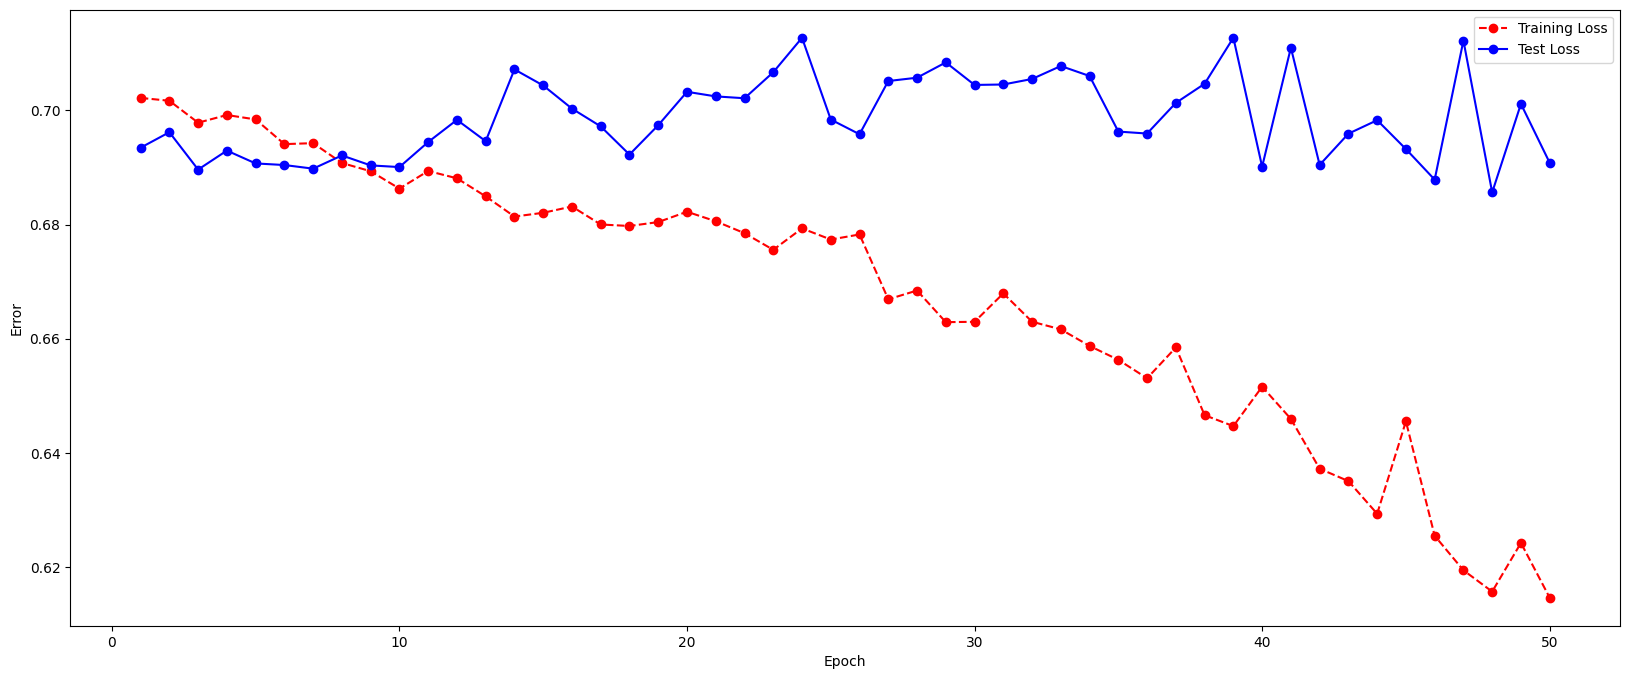

In [34]:
plt.plot(epochs_range, training_loss, 'r',marker="o",linestyle="--")
plt.plot(epochs_range, test_loss, 'b',marker="o",linestyle="-")
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.rcParams["figure.figsize"] = (20,8)
plt.show()

In [11]:
test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"val_loss: {test_accuracy[0]}", f"val_accuracy: {test_accuracy[1]}")

y_i = len(y_values)
i = 0
true_values = 0
while (i < y_i):
    true_values += (1 if (y_test[i][0] == y_prediction[i][0] or y_test[i][1] == y_prediction[i][1]) else 0)
    i = i + 1 
    
print(f"El algoritmo acerto {true_values} veces sobre los {y_i} casos.")

val_loss: 0.7190426588058472 val_accuracy: 0.71875
El algoritmo acerto 230 veces sobre los 320 casos.
